# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

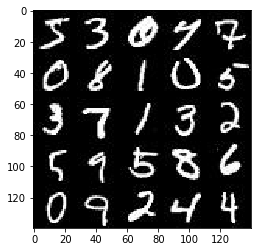

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

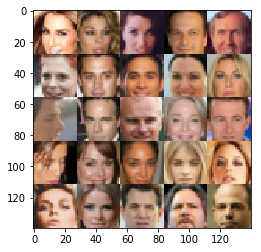

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0-rc1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [40]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [41]:
## Kernel Hyperparamer
kernel_size = 5
alpha = 0.2   #0.2 happens to be the TF default anyway

In [49]:
## Using similar method as in the DCGAN exercise for house numbers.
# Batch Normalization on the 2nd and 3rd hidden layers
# Leaky relu
# Using suggestions from DCGAN paper
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    training = not reuse
    filters = 64
    keep = 0.5
    kernel_initializer = tf.contrib.layers.xavier_initializer()
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, filters, kernel_size, strides=2, padding='same', activation=None,
                             kernel_initializer=kernel_initializer)
        x1 = tf.nn.leaky_relu(x1, alpha=alpha)
        x1 = tf.nn.dropout(x1, keep)
        
        x2 = tf.layers.conv2d(x1, filters*2, kernel_size, strides=2, padding='same', activation=None,
                             kernel_initializer=kernel_initializer)
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.nn.leaky_relu(x2, alpha=alpha)
        x2 = tf.nn.dropout(x2, keep)
        
        x3 = tf.layers.conv2d(x2, filters*4, kernel_size, strides=2, padding='same', activation=None,
                             kernel_initializer=kernel_initializer)
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.nn.leaky_relu(x3, alpha=alpha)
        x3 = tf.nn.dropout(x3, keep)

        flat_x = tf.reshape(x3, (-1,filters*8*4*4))
        logits = tf.layers.dense(flat_x,1)
        output = tf.nn.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [43]:
## Using similar method as in the DCGAN exercise for house numbers.
# Batch Normalization on the all hidden convolution layers
# Leaky relu
def generator(z, out_channel_dim, is_train=True):    #reuse = NOT is_train
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    kernel_initializer = tf.contrib.layers.xavier_initializer()
    with tf.variable_scope('generator', reuse=not is_train):
    # TODO: Implement Function
        # First fully connected layer
        x1 = tf.contrib.layers.fully_connected(z, 7*7*1024, activation_fn=None)
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.nn.leaky_relu(x1, alpha=alpha)
        # Output is 7 x 7 x 512
        #print('x1 dense',x1)

        x2 = tf.layers.conv2d_transpose(x1, 512, kernel_size, strides=2, padding='same', activation=None,
                                       kernel_initializer=kernel_initializer)
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.nn.leaky_relu(x2, alpha=alpha)
        # Output is 14 x 14 x 256
        #print('x2 conv2d',x2)

        x3 = tf.layers.conv2d_transpose(x2, 256, kernel_size, strides=2, padding='same', activation=None,
                                       kernel_initializer=kernel_initializer)
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.nn.leaky_relu(x3, alpha=alpha)
        # Output is 28 x 28 x 128
        #print('x3 conv2d',x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides=1, padding='same',activation=None,
                                            kernel_initializer=kernel_initializer)
        #print('logits',logits)
        # Output s/b 28 x 28 x out_channel_dim
        
        output = tf.tanh(logits)    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [44]:
# Using standard loss formulas from DCGAN
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_output = generator(input_z, out_channel_dim, is_train=True)
    
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_output_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_output_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [45]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, name='d_Adam').minimize(d_loss,var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, name='g_Adam').minimize(g_loss,var_list=g_vars)
        
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [46]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [50]:
losses = []
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    global losses
    print_rate = 25 #Number of steps before updating loss 
    sample_rate = 150 #Number of steps before updating sample pictures
    steps = 0
    
    #Create Networks
    input_real, input_z, input_lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    out_channel_dim = data_shape[3]
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    total_steps = data_shape[0] // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #Double size of batch_images
                batch_images *= 2
                #Get batch of noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})

                if steps % print_rate == 0:
                    # At print_rate interval, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Step {}/{} Epoch {}/{}...".format(steps, total_steps, epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % sample_rate == 0:
                    show_generator_output(sess, 20, input_z, out_channel_dim, data_image_mode)
        print('Final Samples:')
        show_generator_output(sess, 20, input_z, out_channel_dim, data_image_mode)
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 25/1875 Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.5977
Step 50/1875 Epoch 1/2... Discriminator Loss: 1.0392... Generator Loss: 0.5234
Step 75/1875 Epoch 1/2... Discriminator Loss: 1.0186... Generator Loss: 0.5292
Step 100/1875 Epoch 1/2... Discriminator Loss: 0.8065... Generator Loss: 0.6412
Step 125/1875 Epoch 1/2... Discriminator Loss: 0.9635... Generator Loss: 0.6704
Step 150/1875 Epoch 1/2... Discriminator Loss: 0.9197... Generator Loss: 0.6858


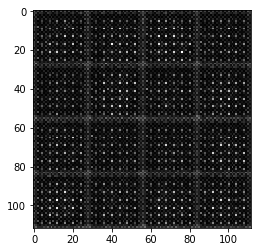

Step 175/1875 Epoch 1/2... Discriminator Loss: 0.3918... Generator Loss: 1.3055
Step 200/1875 Epoch 1/2... Discriminator Loss: 0.8278... Generator Loss: 0.9651
Step 225/1875 Epoch 1/2... Discriminator Loss: 0.6193... Generator Loss: 1.1060
Step 250/1875 Epoch 1/2... Discriminator Loss: 0.5136... Generator Loss: 1.1077
Step 275/1875 Epoch 1/2... Discriminator Loss: 0.8975... Generator Loss: 1.0746
Step 300/1875 Epoch 1/2... Discriminator Loss: 0.7314... Generator Loss: 1.4650


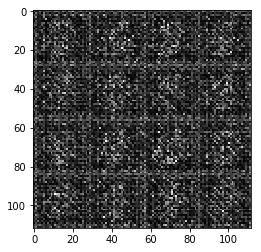

Step 325/1875 Epoch 1/2... Discriminator Loss: 0.6770... Generator Loss: 1.1487
Step 350/1875 Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 0.8078
Step 375/1875 Epoch 1/2... Discriminator Loss: 0.7552... Generator Loss: 1.5151
Step 400/1875 Epoch 1/2... Discriminator Loss: 0.8243... Generator Loss: 0.9772
Step 425/1875 Epoch 1/2... Discriminator Loss: 0.8323... Generator Loss: 0.9001
Step 450/1875 Epoch 1/2... Discriminator Loss: 0.5969... Generator Loss: 1.4400


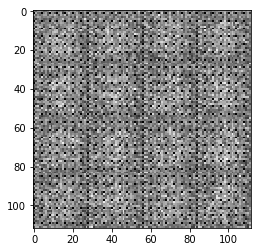

Step 475/1875 Epoch 1/2... Discriminator Loss: 0.6263... Generator Loss: 1.2636
Step 500/1875 Epoch 1/2... Discriminator Loss: 0.3954... Generator Loss: 1.9283
Step 525/1875 Epoch 1/2... Discriminator Loss: 0.2453... Generator Loss: 2.3764
Step 550/1875 Epoch 1/2... Discriminator Loss: 0.3495... Generator Loss: 2.0996
Step 575/1875 Epoch 1/2... Discriminator Loss: 0.2687... Generator Loss: 2.2912
Step 600/1875 Epoch 1/2... Discriminator Loss: 0.2289... Generator Loss: 2.2675


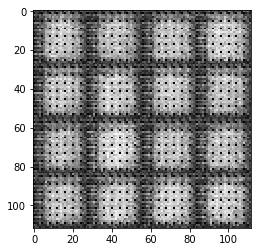

Step 625/1875 Epoch 1/2... Discriminator Loss: 0.1369... Generator Loss: 2.4046
Step 650/1875 Epoch 1/2... Discriminator Loss: 0.1655... Generator Loss: 2.8458
Step 675/1875 Epoch 1/2... Discriminator Loss: 0.1847... Generator Loss: 2.3423
Step 700/1875 Epoch 1/2... Discriminator Loss: 0.3023... Generator Loss: 2.6510
Step 725/1875 Epoch 1/2... Discriminator Loss: 0.1952... Generator Loss: 2.7659
Step 750/1875 Epoch 1/2... Discriminator Loss: 0.1626... Generator Loss: 2.9784


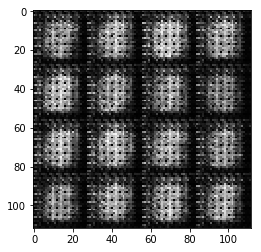

Step 775/1875 Epoch 1/2... Discriminator Loss: 0.2267... Generator Loss: 2.9855
Step 800/1875 Epoch 1/2... Discriminator Loss: 0.2172... Generator Loss: 2.0720
Step 825/1875 Epoch 1/2... Discriminator Loss: 0.1800... Generator Loss: 3.1170
Step 850/1875 Epoch 1/2... Discriminator Loss: 0.1354... Generator Loss: 3.3733
Step 875/1875 Epoch 1/2... Discriminator Loss: 0.1392... Generator Loss: 2.1017
Step 900/1875 Epoch 1/2... Discriminator Loss: 0.4354... Generator Loss: 2.9005


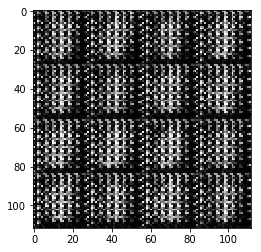

Step 925/1875 Epoch 1/2... Discriminator Loss: 0.2082... Generator Loss: 2.6401
Step 950/1875 Epoch 1/2... Discriminator Loss: 0.1819... Generator Loss: 2.2273
Step 975/1875 Epoch 1/2... Discriminator Loss: 0.1303... Generator Loss: 3.1101
Step 1000/1875 Epoch 1/2... Discriminator Loss: 0.1166... Generator Loss: 2.9652
Step 1025/1875 Epoch 1/2... Discriminator Loss: 0.0748... Generator Loss: 3.8948
Step 1050/1875 Epoch 1/2... Discriminator Loss: 0.2294... Generator Loss: 2.5966


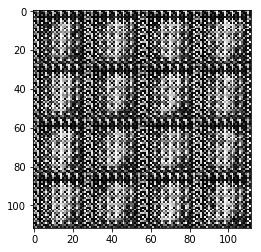

Step 1075/1875 Epoch 1/2... Discriminator Loss: 0.0907... Generator Loss: 2.9838
Step 1100/1875 Epoch 1/2... Discriminator Loss: 0.1501... Generator Loss: 2.6171
Step 1125/1875 Epoch 1/2... Discriminator Loss: 0.1332... Generator Loss: 3.0050
Step 1150/1875 Epoch 1/2... Discriminator Loss: 0.2313... Generator Loss: 3.0169
Step 1175/1875 Epoch 1/2... Discriminator Loss: 0.4017... Generator Loss: 3.3483
Step 1200/1875 Epoch 1/2... Discriminator Loss: 0.2220... Generator Loss: 2.9548


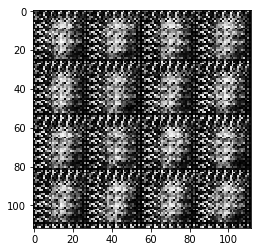

Step 1225/1875 Epoch 1/2... Discriminator Loss: 0.1678... Generator Loss: 3.1300
Step 1250/1875 Epoch 1/2... Discriminator Loss: 0.2267... Generator Loss: 2.7879
Step 1275/1875 Epoch 1/2... Discriminator Loss: 0.1150... Generator Loss: 3.4604
Step 1300/1875 Epoch 1/2... Discriminator Loss: 0.1547... Generator Loss: 3.3184
Step 1325/1875 Epoch 1/2... Discriminator Loss: 0.1707... Generator Loss: 3.4245
Step 1350/1875 Epoch 1/2... Discriminator Loss: 0.1592... Generator Loss: 3.6346


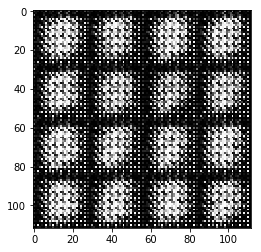

Step 1375/1875 Epoch 1/2... Discriminator Loss: 0.1811... Generator Loss: 2.6405
Step 1400/1875 Epoch 1/2... Discriminator Loss: 0.0736... Generator Loss: 3.7427
Step 1425/1875 Epoch 1/2... Discriminator Loss: 0.1514... Generator Loss: 3.2465
Step 1450/1875 Epoch 1/2... Discriminator Loss: 0.0828... Generator Loss: 4.2402
Step 1475/1875 Epoch 1/2... Discriminator Loss: 0.1792... Generator Loss: 2.9849
Step 1500/1875 Epoch 1/2... Discriminator Loss: 0.1998... Generator Loss: 3.6353


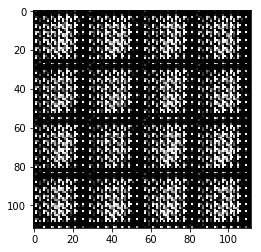

Step 1525/1875 Epoch 1/2... Discriminator Loss: 0.1202... Generator Loss: 4.5525
Step 1550/1875 Epoch 1/2... Discriminator Loss: 0.0954... Generator Loss: 3.9116
Step 1575/1875 Epoch 1/2... Discriminator Loss: 0.1797... Generator Loss: 3.3421
Step 1600/1875 Epoch 1/2... Discriminator Loss: 0.2547... Generator Loss: 3.4382
Step 1625/1875 Epoch 1/2... Discriminator Loss: 0.1395... Generator Loss: 3.2960
Step 1650/1875 Epoch 1/2... Discriminator Loss: 0.1182... Generator Loss: 3.8983


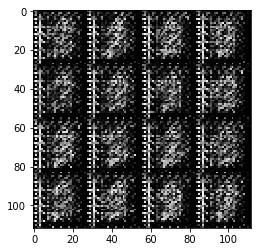

Step 1675/1875 Epoch 1/2... Discriminator Loss: 0.1993... Generator Loss: 3.5301
Step 1700/1875 Epoch 1/2... Discriminator Loss: 0.1194... Generator Loss: 3.6320
Step 1725/1875 Epoch 1/2... Discriminator Loss: 0.1467... Generator Loss: 2.8190
Step 1750/1875 Epoch 1/2... Discriminator Loss: 0.0836... Generator Loss: 3.7677
Step 1775/1875 Epoch 1/2... Discriminator Loss: 0.1097... Generator Loss: 3.9597
Step 1800/1875 Epoch 1/2... Discriminator Loss: 0.1410... Generator Loss: 3.2269


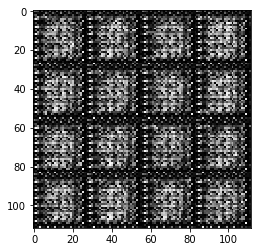

Step 1825/1875 Epoch 1/2... Discriminator Loss: 0.0922... Generator Loss: 2.6934
Step 1850/1875 Epoch 1/2... Discriminator Loss: 0.1298... Generator Loss: 3.5880
Step 1875/1875 Epoch 1/2... Discriminator Loss: 0.0968... Generator Loss: 3.7133
Step 1900/1875 Epoch 2/2... Discriminator Loss: 0.1535... Generator Loss: 3.6018
Step 1925/1875 Epoch 2/2... Discriminator Loss: 0.1221... Generator Loss: 3.5114
Step 1950/1875 Epoch 2/2... Discriminator Loss: 0.1183... Generator Loss: 3.0869


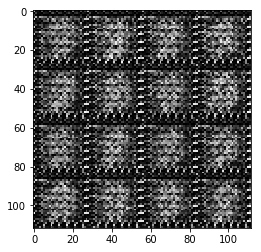

Step 1975/1875 Epoch 2/2... Discriminator Loss: 0.1653... Generator Loss: 3.4194
Step 2000/1875 Epoch 2/2... Discriminator Loss: 0.0988... Generator Loss: 2.9847
Step 2025/1875 Epoch 2/2... Discriminator Loss: 0.1103... Generator Loss: 3.4908
Step 2050/1875 Epoch 2/2... Discriminator Loss: 0.1150... Generator Loss: 3.3707
Step 2075/1875 Epoch 2/2... Discriminator Loss: 0.0734... Generator Loss: 3.2353
Step 2100/1875 Epoch 2/2... Discriminator Loss: 0.0608... Generator Loss: 3.7675


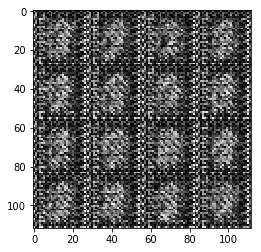

Step 2125/1875 Epoch 2/2... Discriminator Loss: 0.1320... Generator Loss: 3.8062
Step 2150/1875 Epoch 2/2... Discriminator Loss: 0.0808... Generator Loss: 3.4586
Step 2175/1875 Epoch 2/2... Discriminator Loss: 0.0659... Generator Loss: 3.9838
Step 2200/1875 Epoch 2/2... Discriminator Loss: 0.1266... Generator Loss: 3.5564
Step 2225/1875 Epoch 2/2... Discriminator Loss: 0.1009... Generator Loss: 4.0234
Step 2250/1875 Epoch 2/2... Discriminator Loss: 0.0815... Generator Loss: 3.8874


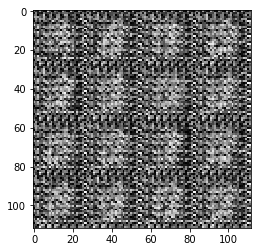

Step 2275/1875 Epoch 2/2... Discriminator Loss: 0.0708... Generator Loss: 3.6283
Step 2300/1875 Epoch 2/2... Discriminator Loss: 0.0802... Generator Loss: 3.3784
Step 2325/1875 Epoch 2/2... Discriminator Loss: 0.0950... Generator Loss: 3.2427
Step 2350/1875 Epoch 2/2... Discriminator Loss: 0.0970... Generator Loss: 3.2415
Step 2375/1875 Epoch 2/2... Discriminator Loss: 0.0566... Generator Loss: 3.4926
Step 2400/1875 Epoch 2/2... Discriminator Loss: 0.1016... Generator Loss: 3.4250


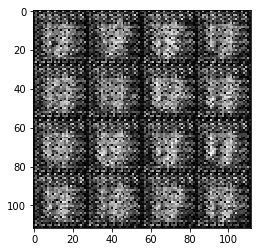

Step 2425/1875 Epoch 2/2... Discriminator Loss: 0.0703... Generator Loss: 3.1111
Step 2450/1875 Epoch 2/2... Discriminator Loss: 0.0358... Generator Loss: 3.8385
Step 2475/1875 Epoch 2/2... Discriminator Loss: 0.0780... Generator Loss: 4.2090
Step 2500/1875 Epoch 2/2... Discriminator Loss: 0.0595... Generator Loss: 3.5186
Step 2525/1875 Epoch 2/2... Discriminator Loss: 0.0701... Generator Loss: 3.6439
Step 2550/1875 Epoch 2/2... Discriminator Loss: 0.0542... Generator Loss: 3.4695


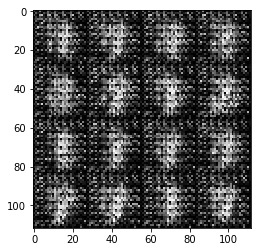

Step 2575/1875 Epoch 2/2... Discriminator Loss: 0.0548... Generator Loss: 3.3537
Step 2600/1875 Epoch 2/2... Discriminator Loss: 0.0739... Generator Loss: 3.5289
Step 2625/1875 Epoch 2/2... Discriminator Loss: 0.0916... Generator Loss: 3.4130
Step 2650/1875 Epoch 2/2... Discriminator Loss: 0.0937... Generator Loss: 4.2131
Step 2675/1875 Epoch 2/2... Discriminator Loss: 0.1493... Generator Loss: 3.5858
Step 2700/1875 Epoch 2/2... Discriminator Loss: 0.0555... Generator Loss: 3.9041


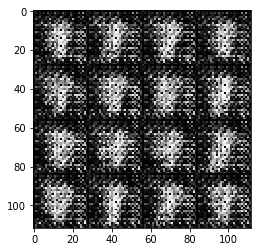

Step 2725/1875 Epoch 2/2... Discriminator Loss: 0.0589... Generator Loss: 3.7350
Step 2750/1875 Epoch 2/2... Discriminator Loss: 0.0604... Generator Loss: 3.9586
Step 2775/1875 Epoch 2/2... Discriminator Loss: 0.1076... Generator Loss: 3.5333
Step 2800/1875 Epoch 2/2... Discriminator Loss: 0.0550... Generator Loss: 3.3832
Step 2825/1875 Epoch 2/2... Discriminator Loss: 0.0483... Generator Loss: 3.5665
Step 2850/1875 Epoch 2/2... Discriminator Loss: 0.0741... Generator Loss: 3.4532


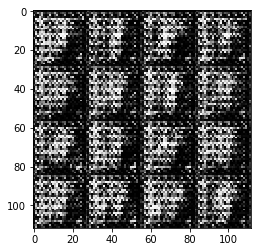

Step 2875/1875 Epoch 2/2... Discriminator Loss: 0.0778... Generator Loss: 4.6214
Step 2900/1875 Epoch 2/2... Discriminator Loss: 0.0567... Generator Loss: 4.0074
Step 2925/1875 Epoch 2/2... Discriminator Loss: 0.0907... Generator Loss: 4.1099
Step 2950/1875 Epoch 2/2... Discriminator Loss: 0.0623... Generator Loss: 4.2485
Step 2975/1875 Epoch 2/2... Discriminator Loss: 0.0775... Generator Loss: 3.7264
Step 3000/1875 Epoch 2/2... Discriminator Loss: 0.0597... Generator Loss: 3.8538


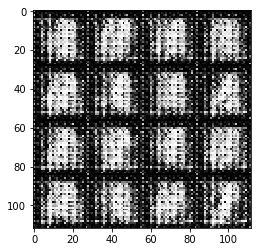

Step 3025/1875 Epoch 2/2... Discriminator Loss: 0.0712... Generator Loss: 4.2242
Step 3050/1875 Epoch 2/2... Discriminator Loss: 0.1164... Generator Loss: 3.5207
Step 3075/1875 Epoch 2/2... Discriminator Loss: 0.0707... Generator Loss: 3.8373
Step 3100/1875 Epoch 2/2... Discriminator Loss: 0.0917... Generator Loss: 2.2392
Step 3125/1875 Epoch 2/2... Discriminator Loss: 0.0585... Generator Loss: 4.3963
Step 3150/1875 Epoch 2/2... Discriminator Loss: 0.0612... Generator Loss: 4.1255


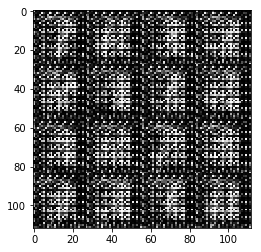

Step 3175/1875 Epoch 2/2... Discriminator Loss: 0.0820... Generator Loss: 3.8130
Step 3200/1875 Epoch 2/2... Discriminator Loss: 0.0523... Generator Loss: 4.2717
Step 3225/1875 Epoch 2/2... Discriminator Loss: 0.1529... Generator Loss: 3.5633
Step 3250/1875 Epoch 2/2... Discriminator Loss: 0.0999... Generator Loss: 4.3450
Step 3275/1875 Epoch 2/2... Discriminator Loss: 0.0708... Generator Loss: 4.1998
Step 3300/1875 Epoch 2/2... Discriminator Loss: 0.0649... Generator Loss: 4.0643


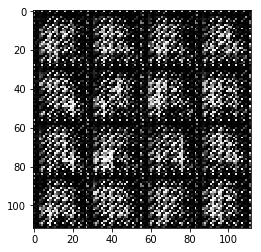

Step 3325/1875 Epoch 2/2... Discriminator Loss: 0.0638... Generator Loss: 3.5083
Step 3350/1875 Epoch 2/2... Discriminator Loss: 0.0446... Generator Loss: 4.1981
Step 3375/1875 Epoch 2/2... Discriminator Loss: 0.0539... Generator Loss: 4.1821
Step 3400/1875 Epoch 2/2... Discriminator Loss: 0.0640... Generator Loss: 3.5486
Step 3425/1875 Epoch 2/2... Discriminator Loss: 0.0381... Generator Loss: 4.2816
Step 3450/1875 Epoch 2/2... Discriminator Loss: 0.0654... Generator Loss: 5.0544


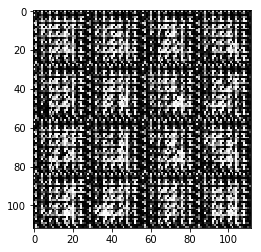

Step 3475/1875 Epoch 2/2... Discriminator Loss: 0.1119... Generator Loss: 4.6767
Step 3500/1875 Epoch 2/2... Discriminator Loss: 0.0634... Generator Loss: 4.9615
Step 3525/1875 Epoch 2/2... Discriminator Loss: 0.0424... Generator Loss: 4.5618
Step 3550/1875 Epoch 2/2... Discriminator Loss: 0.0360... Generator Loss: 3.6582
Step 3575/1875 Epoch 2/2... Discriminator Loss: 0.0216... Generator Loss: 4.4469
Step 3600/1875 Epoch 2/2... Discriminator Loss: 0.0336... Generator Loss: 4.5813


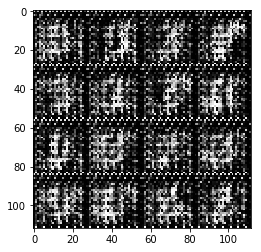

Step 3625/1875 Epoch 2/2... Discriminator Loss: 0.0308... Generator Loss: 5.0332
Step 3650/1875 Epoch 2/2... Discriminator Loss: 0.0737... Generator Loss: 4.5123
Step 3675/1875 Epoch 2/2... Discriminator Loss: 0.0190... Generator Loss: 5.3598
Step 3700/1875 Epoch 2/2... Discriminator Loss: 0.0430... Generator Loss: 4.3823
Step 3725/1875 Epoch 2/2... Discriminator Loss: 0.0525... Generator Loss: 4.5665
Step 3750/1875 Epoch 2/2... Discriminator Loss: 0.1010... Generator Loss: 4.6548


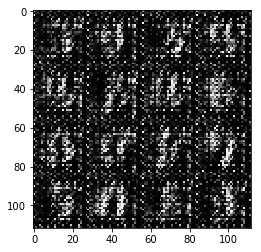

Final Samples:


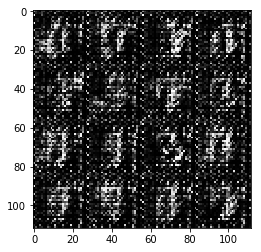

In [52]:
batch_size = 32
z_dim = 100
learning_rate = 0.00001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## Plot Losses of Discriminator and Generator
Here we will plot the losses by step increment, not epoch since there are not enough epochs.  This may not reveal anything.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
nplosses = np.array(losses)
plt.plot(nplosses.T[0], label='Discriminator')
plt.plot(nplosses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.01
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

#celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
#with tf.Graph().as_default():
#    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
#          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.